In [1]:
using Revise
using OpenFASTsr, DelimitedFiles, GXBeam, Rotors, LinearAlgebra, DynamicStallModels
using YAML
using Infiltrator
using StaticArrays
# using Plots

DS = DynamicStallModels
of = OpenFASTsr

localpath = @__DIR__
cd(localpath)


### Read in OpenFAST files
ofpath = "./" 
inputfile = of.read_inputfile("sn5_input.fst", ofpath)
inflowwind = of.read_inflowwind("sn5_inflowwind.dat", ofpath)
# addriver = of.read_addriver("sn5_ADdriver.dvr", ofpath)
adfile = of.read_adfile("sn5_ADfile.dat", ofpath)
adblade = of.read_adblade("sn5_ADblade.dat", ofpath)
edfile = of.read_edfile("sn5_edfile.dat", ofpath)
bdfile = of.read_bdfile("sn5_bdfile.dat", ofpath)
bdblade = of.read_bdblade("sn5_bdblade.dat", ofpath)

B = edfile["NumBl"] #Number of Blades

rhub = edfile["HubRad"]
rvec = adblade["BlSpn"] .+ rhub
rtip = rvec[end]
rfrac = bdblade["rfrac"]
chordvec = adblade["BlChord"]
twistvec = adblade["BlTwist"]

### Simulation corrections? 
rvec[1] += 0.001 
rtip = 63.0

hubht = inflowwind["RefHt"]
pitch = edfile["BlPitch(1)"]
precone = edfile["PreCone(1)"]*pi/180 
yaw = edfile["NacYaw"]*(pi/180) 
tilt = edfile["ShftTilt"]*(pi/180)

rho = inputfile["AirDens"]
mu = inputfile["KinVisc"]
vinf = inflowwind["HWindSpeed"]
a = inputfile["SpdSound"]
omega = edfile["RotSpeed"]*2*pi/60 #Convert to rads/s
shearexp = inflowwind["PLexp"]
tsr = omega*rtip/vinf

env = Rotors.environment(rho, mu, a, vinf, omega, shearexp)



n = length(adblade["BlSpn"])
ne = Int(bdblade["station_total"])

if !@isdefined(readflag)
    readflag = true
end

if readflag
    # fullouts = readdlm("./simpleNREL/sn5_ADdriver.1.out", skipstart=6)
    fullouts = readdlm("./sn5_input.out", skipstart=6)

    names = fullouts[1,:]

    # data = readdlm("./simpleNREL/sn5_ADdriver.1.out", skipstart=8)
    # data = readdlm("./simpleNREL/sn5_input.out", skipstart=8)
    data = Float64.(fullouts[3:end,:])

    outs = Dict(names[i] => data[:,i] for i in eachindex(names))

    tvec = outs["Time"]


    nt = length(tvec)


    global fxmat = zeros(nt, n)
    global fymat = zeros(nt, n)
    # global Uxmat = zeros(nt, n)
    # global Uymat = zeros(nt, n)
    global Mmat = zeros(nt, n)
    # global alphamat = zeros(nt, n)

    for i = 1:n
        if i<10
            number = "00$i"
        elseif i<100
            number = "0$i"
        else
            number = "$i"
        end
        namex = "AB1N"*number*"Fx"
        namey = "AB1N"*number*"Fy"
        nameux = "AB1N"*number*"Vx" 
        nameuy = "AB1N"*number*"Vy"
        namem = "AB1N"*number*"Mm"
        
        # namealpha = "AB1N"*number*"Alpha"

        fxmat[:,i] = outs[namex]
        fymat[:,i] = outs[namey]
        # Uxmat[:,i] = outs[nameux]
        # Uymat[:,i] = outs[nameuy]
        Mmat[:,i] = outs[namem]
        # alphamat[:,i] = outs[namealpha]
    end

    # global dxmat = zeros(nt, ne)
    # global dymat = zeros(nt, ne)
    # global dzmat = zeros(nt, ne)
    # # global Dxmat = zeros(nt, ne)
    # # global Dymat = zeros(nt, ne)
    # # global Dzmat = zeros(nt, ne)
    # global Vxmat = zeros(nt, ne)
    # global Vymat = zeros(nt, ne)
    # global Vzmat = zeros(nt, ne)
    # global Wxmat = zeros(nt, ne)
    # global Wymat = zeros(nt, ne)
    # global Wzmat = zeros(nt, ne)

    # for i = 1:ne
    #     if i<10
    #         number = "00$i"
    #     elseif i<100
    #         number = "0$i"
    #     else
    #         number = "$i"
    #     end

    #     namedx = "B1N"*number*"_TDxr"
    #     namedy = "B1N"*number*"_TDyr"
    #     namedz = "B1N"*number*"_TDzr"
    #     # namebx = "B1N"*number*"_FxR"
    #     # nameby = "B1N"*number*"_FyR"
    #     # namebz = "B1N"*number*"_FzR"
    #     namevx = "B1N"*number*"_TVxr"
    #     namevy = "B1N"*number*"_TVyr"
    #     namevz = "B1N"*number*"_TVzr"
    #     namewx = "B1N"*number*"_RVxr"
    #     namewy = "B1N"*number*"_RVyr"
    #     namewz = "B1N"*number*"_RVzr"

    #     dxmat[:,i] = outs[namedx]
    #     dymat[:,i] = outs[namedy]
    #     dzmat[:,i] = outs[namedz]
    #     # Dxmat[:,i] = outs[namebx]
    #     # Dymat[:,i] = outs[nameby]
    #     # Dzmat[:,i] = outs[namebz]
    #     Vxmat[:,i] = outs[namevx]
    #     Vymat[:,i] = outs[namevy]
    #     Vzmat[:,i] = outs[namevz]
    #     Wxmat[:,i] = outs[namewx]
    #     Wymat[:,i] = outs[namewy]
    #     Wzmat[:,i] = outs[namewz]

    # end

    yamlfile = YAML.load_file("sn5_input.BD1.sum.yaml")
    

    # nfea = 150
    # nelem = 1
    # rnodes = zeros(nfea)

    # global tempij = 1
    # for i = 1:nelem
    #     global tempij

    #     temp = yamlfile["Init_QP_E$i"]
    #     rnodes[tempij] = temp[1][3]
    #     tempij += 1

    #     rnodes[tempij] = temp[2][3]
    #     tempij += 1

    #     rnodes[tempij] = temp[3][3]
    #     tempij += 1

    # end
    # rnodes .+= rhub

    nfea = 9
    rnodes = zeros(nfea)
    temp = yamlfile["Init_Nodes_E1"]

    for i = 1:nfea
        rnodes[i] = temp[i][3]
    end

    global dxmat = zeros(nt, nfea)
    global dymat = zeros(nt, nfea)
    global dzmat = zeros(nt, nfea)
    global dfx = zeros(nt, nfea)
    global dfy = zeros(nt, nfea)
    global dfz = zeros(nt, nfea)

    for i = 1:nfea
        if i<10
            number = "00$i"
        elseif i<100
            number = "0$i"
        else
            number = "$i"
        end

        namedx = "B1N"*number*"_TDxr"
        namedy = "B1N"*number*"_TDyr"
        namedz = "B1N"*number*"_TDzr"
        # namedfx = "B1N"*number*"_DFxR"
        # namedfy = "B1N"*number*"_DFyR"
        # namedfz = "B1N"*number*"_DFzR"

        dxmat[:,i] = outs[namedx]
        dymat[:,i] = outs[namedy]
        dzmat[:,i] = outs[namedz]
        # dfx[:,i] = outs[namedfx]
        # dfy[:,i] = outs[namedfy]
        # dfz[:,i] = outs[namedfz]
    end

    # global rdx = zeros(nt, ne)
    # global rdy = zeros(nt, ne)
    # global rdz = zeros(nt, ne)
    # global dfx = zeros(nt, ne)
    # global dfy = zeros(nt, ne)
    # global dfz = zeros(nt, ne)

    # for i = 1:ne
    #     if i<10
    #         number = "00$i"
    #     elseif i<100
    #         number = "0$i"
    #     else
    #         number = "$i"
    #     end

    #     namedx = "B1N"*number*"_RDxr"
    #     namedy = "B1N"*number*"_RDyr"
    #     namedz = "B1N"*number*"_RDzr"
    #     namedfx = "B1N"*number*"_DFxR"
    #     namedfy = "B1N"*number*"_DFyR"
    #     namedfz = "B1N"*number*"_DFzR"

    #     rdx[:,i] = outs[namedx]
    #     rdy[:,i] = outs[namedy]
    #     rdz[:,i] = outs[namedz]
    #     dfx[:,i] = outs[namedfx]
    #     dfy[:,i] = outs[namedfy]
    #     dfz[:,i] = outs[namedfz]
    # end

    intermediatefile = readdlm("BLADG_intermediate_states.txt")

    inames = intermediatefile[1,:]
    idata = intermediatefile[2:end, :]

    iouts = Dict(inames[i] => idata[:,i] for i in eachindex(inames))

    bemif = readdlm("BEM_intermediate_states.txt")
    bemnames = ["i", "theta", "cant", "toe", "Vx", "Vy", "Vz", "chord"]

    bouts = Dict(bemnames[i] => bemif[:,i] for i in eachindex(bemnames))

    readflag = false
end

azimuth = outs["B1Azimuth"].*(pi/180)
tipdx = outs["B1TipTDxr"]
tipdy = outs["B1TipTDyr"]
tipdz = outs["B1TipTDzr"]


assembly = of.make_assembly(edfile, bdfile, bdblade)

### Prep the ASD rotor and operating conditions 
aftypes = Array{of.AirfoilInput}(undef, 8)
aftypes[1] = of.read_airfoilinput("./Airfoils/Cylinder1.dat") 
aftypes[2] = of.read_airfoilinput("./Airfoils/Cylinder2.dat") 
aftypes[3] = of.read_airfoilinput("./Airfoils/DU40_A17.dat") 
aftypes[4] = of.read_airfoilinput("./Airfoils/DU35_A17.dat") 
aftypes[5] = of.read_airfoilinput("./Airfoils/DU30_A17.dat") 
aftypes[6] = of.read_airfoilinput("./Airfoils/DU25_A17.dat") 
aftypes[7] = of.read_airfoilinput("./Airfoils/DU21_A17.dat") 
aftypes[8] = of.read_airfoilinput("./Airfoils/NACA64_A17.dat") 

# indices correspond to which airfoil is used at which station
af_idx = Int.(adblade["BlAFID"])


# create airfoil array
afs = aftypes[af_idx]

n = length(rvec)
airfoils = Vector{DS.Airfoil}(undef, n)
for i = 1:n
    airfoils[i] = make_dsairfoil(afs[i], chordvec[i])
end

rR = rvec./rtip
# blade = Rotors.Blade(rhub, rtip, rR, airfoils)
blade = Rotors.Blade(rvec, twistvec.*(pi/180), airfoils; rhub=rhub, rtip=rtip, precone)

turbine = true
rotor_r = Rotors.Rotor(Int(B), hubht, turbine; tilt, yaw)


# dsmodel = DS.BeddoesLeishman(DS.Indicial(), n, airfoils, 3)
# dsmodelinit = Rotors.BeddoesLeishman()

if !@isdefined(runflag)
    runflag = true
end




if runflag
    loads, cchistory, xds, gxhistory = Rotors.simulate(rotor_r, blade, env, assembly, tvec; verbose=true, speakiter=1000, g=inputfile["Gravity"], plotbool=false, plotiter=20)
    # Fx, Fy, Mx, cchistory, xds, gxhistory = Rotors.simulate(rotor_r, blade, env, assembly, tvec; verbose=true, speakiter=1000, g=inputfile["Gravity"], plotbool=false, plotiter=20)

    runflag = false
end


# tvecsample = 0:0.001:0.5

# Rotors.simulate(rotor_r, blade, env, assembly, tvec; verbose=true, speakiter=1000, g=inputfile["Gravity"], plotbool=false, plotiter=20)

# @time Rotors.simulate(rotor_r, blade, env, assembly, tvec; verbose=true, speakiter=1000, g=inputfile["Gravity"], plotbool=false, plotiter=20)
nothing
# using Profile

# @profile Rotors.simulate(rotor_r, blade, env, assembly, tvec; verbose=true, speakiter=1000, g=inputfile["Gravity"], plotbool=false, plotiter=20)

# open("./prof.txt", "w") do s
    
#     Profile.print(IOContext(s); combine=true)
# end


    
# nothing

# @code_warntype Rotors.simulate(rotor_r, blade, env, assembly, tvec; verbose=false, speakiter=1000, g=inputfile["Gravity"], plotbool=false, plotiter=20)

#Note: Current only type instability is the return tuple. I don't know if that is something that I can really fix. :| 

#





nothing

Rotors.jl initializing solution...



Simulation time: 1.0


Rotors.jl initializing solution...



Simulation time: 1.0


Rotors.jl initializing solution...



Simulation time: 1.0


┌ Warning: The depth of this graph is 55, exceeding the `maxdepth` (=50).
│ The deeper frames will be truncated.
└ @ ProfileSVG /Users/adamcardoza/.julia/packages/ProfileSVG/ecSyU/src/ProfileSVG.jl:275
┌ Warning: The maximum number of frames (`maxframes`=2000) is reached.
│ Some frames were truncated.
└ @ ProfileSVG /Users/adamcardoza/.julia/packages/ProfileSVG/ecSyU/src/ProfileSVG.jl:333


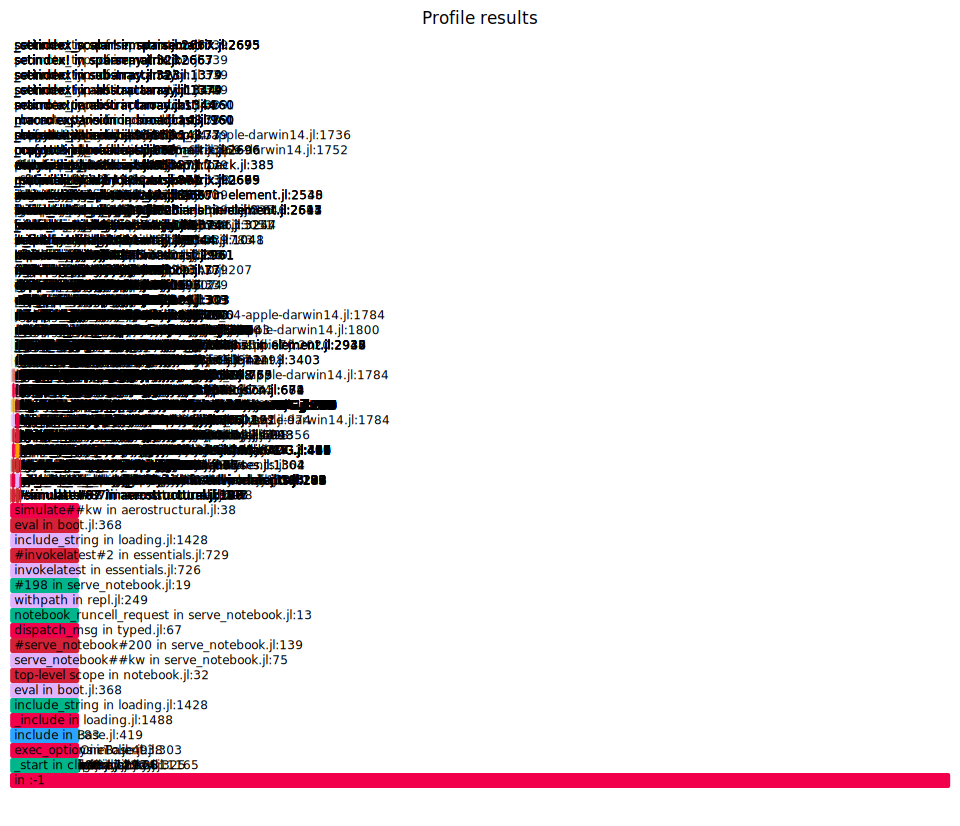

┌ Warning: The depth of this graph is 55, exceeding the `maxdepth` (=50).
│ The deeper frames will be truncated.
└ @ ProfileSVG /Users/adamcardoza/.julia/packages/ProfileSVG/ecSyU/src/ProfileSVG.jl:275
┌ Warning: The maximum number of frames (`maxframes`=2000) is reached.
│ Some frames were truncated.
└ @ ProfileSVG /Users/adamcardoza/.julia/packages/ProfileSVG/ecSyU/src/ProfileSVG.jl:333


In [2]:
using Profile, ProfileSVG

ProfileSVG.@profview Rotors.simulate(rotor_r, blade, env, assembly, tvec; verbose=true, speakiter=1000, g=inputfile["Gravity"], plotbool=false, plotiter=20)

In [ ]:
nothing
 
#Tip deflections
tipdef_x = [gxhistory[i].points[end].u[1] for i in eachindex(tvec)]
tipdef_y = [gxhistory[i].points[end].u[2] for i in eachindex(tvec)]
tipdef_z = [gxhistory[i].points[end].u[3] for i in eachindex(tvec)]

tiptheta_x = zeros(nt)
tiptheta_y = zeros(nt)
tiptheta_z = zeros(nt)

tiptheta_xof = zeros(nt)
tiptheta_yof = zeros(nt)
tiptheta_zof = zeros(nt)

for i = 1:nt
    theta = Rotors.WMPtoangle(gxhistory[i].points[end].theta)
    tiptheta_x[i] = theta[1]
    tiptheta_y[i] = theta[2]
    tiptheta_z[i] = theta[3]

    thetawmp = SVector(outs["B1TipRDxr"][i], outs["B1TipRDyr"][i], outs["B1TipRDzr"][i])
    theta = Rotors.WMPtoangle(thetawmp)
    tiptheta_xof[i] = theta[1]
    tiptheta_yof[i] = theta[2]
    tiptheta_zof[i] = theta[3]
end

nr = length(rvec)
nt = length(tvec)
defx_gx = zeros(nt, nr)
defy_gx = zeros(nt, nr)
defz_gx = zeros(nt, nr)

for i in eachindex(tvec)
    for j in eachindex(rvec)
        defx_gx[i,j] = gxhistory[i].points[j].u[1]
        defy_gx[i,j] = gxhistory[i].points[j].u[2]
        defz_gx[i,j] = gxhistory[i].points[j].u[3]
    end
end






# using Plots, LaTeXStrings






# tiploads = plot(xaxis="Time (s)", yaxis="Tip Load (N)", legend=:outerright)
# plot!(tvec, fxmat[:,end], lab=L"$F_x$ - OF", seriescolor=:blue)
# plot!(tvec, -fymat[:,end], lab=L"$F_y$ - OF", seriescolor=:red)
# # plot!(tvec, Mmat[:,end], lab=L"$M_z$ - OF", seriescolor=:green)
# plot!(tvec, loads.Fx[:,end], lab=L"$F_x$ - R", linestyle=:dash)
# plot!(tvec, loads.Fy[:,end], lab=L"$F_y$ - R", linestyle=:dash)
# # plot!(tvec, loads.M[:,end], lab=L"D_z", linestyle=:dash)
# display(tiploads)



# tipdefs2 = plot(xaxis="Time (s)", yaxis="Tip Deflection (m)", legend=(0.8, 0.3)) #
# plot!(tvec, tipdx, lab=L"$\delta x$ - OF", linestyle=:dash)
# plot!(tvec, tipdy, lab=L"$\delta y$ - OF", linestyle=:dash)
# plot!(tvec, tipdz, lab=L"$\delta z$ - OF", linestyle=:dash)
# plot!(tvec, -tipdef_z, lab=L"\delta x")
# plot!(tvec, tipdef_y, lab=L"\delta y")
# plot!(tvec, tipdef_x, lab=L"\delta z")
# display(tipdefs2)


# using Statistics

# tiploaderr = @. 100*(loads.Fx[:,end] - fxmat[:,end])./fxmat[:,end]
# tipdeferr = @. (-tipdef_z-tipdx)

# meantiploaderr = mean(tiploaderr)
# meantipdeferr = mean(tipdeferr)

nothing